# Generative Adversarial Network to Augmentate Limited Image Dataset

Project Outline : 
1. Applying the Generative Adversarial Network, consisting of combination generator and descriminator models, to augment the similar data for better training further models
2. Hyperparameter or architecture tuning on the GANs model to find the best accuracy model based on FID Score

In [21]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

Before dived deeper into the model, because the notebook is separated, then it is a must to import and preprocess the image dataset again.

In [3]:
target_size = 100
image_size = 100
image_shape = (100,100,3)
batch_size = 32
latent_dim = 192

Unlocking the Image Dataset

In [4]:
df_path = "G:/My Drive/1. Binus University/4th Semester/Deep Learning/UAS/A_23"

images = []
images_path = []

for filename in os.listdir(df_path):
    img_path = os.path.join(df_path, filename)
    img = Image.open(img_path)
    images.append(np.array(img))
    images_path.append(img_path)

Image Resizing

In [5]:
images = []

for path in images_path:
    img = cv2.imread(path)
    resized_image = cv2.resize(img, (target_size, target_size))
    images.append(np.array(resized_image))

In [6]:
shapes = [img.shape for img in images]
heights = [shape[0] for shape in shapes]
widths = [shape[1] for shape in shapes]
channels = [shape[2] if len(shape) == 3 else 1 for shape in shapes]

print("=== Image Dimension ===")
print(f"Height: min -> {min(heights)}, max -> {max(heights)}")
print(f"Width: min -> {min(widths)}, max= -> {max(widths)}")
print(f"Channels: {set(channels)}")

=== Image Dimension ===
Height: min -> 100, max -> 100
Width: min -> 100, max= -> 100
Channels: {3}


Image Normalization

In [7]:
x = np.array(images).astype(np.float32)
x = (x / 127.5) - 1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


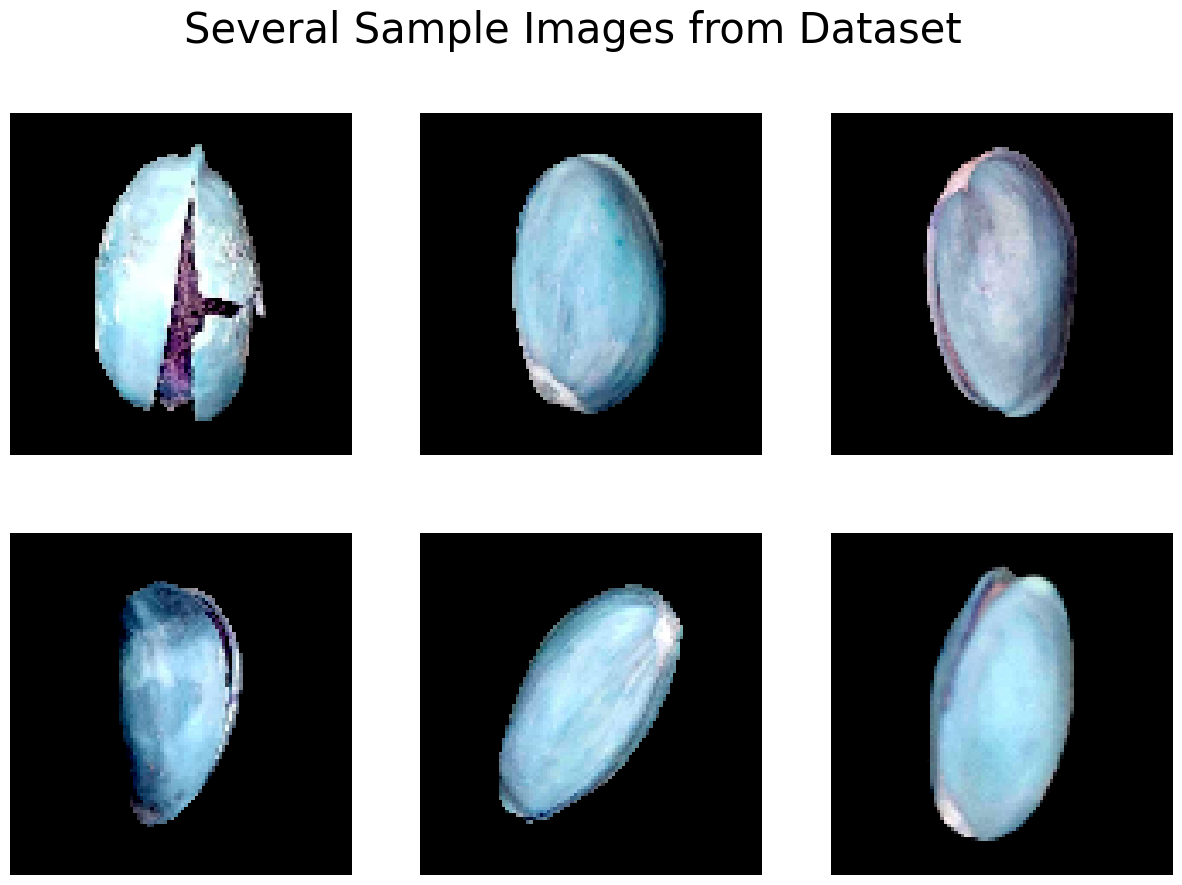

In [8]:
n_samples = min(6, len(images))
sample_indices = np.random.choice(len(images), n_samples, replace = False)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle("Several Sample Images from Dataset", fontsize = 30)

for i, idx in enumerate(sample_indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(x[idx])
    axes[row, col].axis("off")

plt.show()

# 3.a. Modelling Generative Advesarial Network

Develop Generator Architecture

In [9]:
def build_generator():
    input_noise = Input(shape=(latent_dim,))
    
    x = Dense(92*92*3, activation='relu')(input_noise)
    x = Reshape((92, 92, 3))(x)
    x = Conv2DTranspose(16, (3,3), strides=1, padding='valid', activation='relu')(x)
    x = Conv2DTranspose(32, (3,3), strides=1, padding='valid', activation='relu')(x)
    x = Conv2DTranspose(64, (3,3), strides=1, padding='valid', activation='relu')(x)

    output_img = Conv2DTranspose(3, (3,3), strides=1, padding='valid', activation='tanh')(x)

    model = Model(input_noise, output_img, name='Generator')

    return model

Develop Discriminator Architecture

In [10]:
def build_discriminator():
    input_image = Input(shape = image_shape)

    x = Conv2D(16, (3,3), strides=1, padding='valid', activation='relu')(input_image)
    x = Conv2D(32, (3,3), strides=1, padding='valid', activation='relu')(x)
    x = Conv2D(64, (3,3), strides=1, padding='valid', activation='relu')(x)
    x = Flatten()(x)

    output_image = Dense(1, activation='sigmoid')(x)

    model = Model(input_image, output_image, name='Discriminator')
    
    return model


Combine Generator and Discriminator to GAN Architecture

In [11]:
base_generator = build_generator()
base_discriminator = build_discriminator()
base_discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

base_discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_img = base_generator(z)
validity = base_discriminator(generated_img)

base_GAN = Model(z, validity, name = "GAN")
base_GAN.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

base_generator.summary()
base_discriminator.summary()
base_GAN.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25392)          │     4,900,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 92, 92, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 94, 94, 16)     │           448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 96, 96, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 98, 98, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,925,971 (18.79 MB)

 Trainable params: 4,925,971 (18.79 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 589,089 (2.25 MB)

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 100, 100, 3)    │     4,925,971 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │       589,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,515,060 (21.04 MB)

 Trainable params: 4,925,971 (18.79 MB)

 Non-trainable params: 589,089 (2.25 MB)

Build a Function to train the GANs Architecture

In [12]:
def train_GAN(generator, discriminator, GAN, data, latent_dim=latent_dim, epochs=1000, batch_size=batch_size, steps_per_epoch=x.shape[0]//batch_size):
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_img = data[idx]

            noise = np.random.normal(0,1,(batch_size, latent_dim))
            fake_img = generator.predict(noise, verbose = 0)

            real_label = np.ones((batch_size, 1))
            fake_label = np.zeros((batch_size, 1))

            discriminator.trainable = True
            d_loss_realimg = discriminator.train_on_batch(real_img, real_label)
            d_loss_fakeimg = discriminator.train_on_batch(fake_img, fake_label)
            d_loss = 0.5 * np.add(d_loss_realimg, d_loss_fakeimg)

            noise = np.random.normal(0,1,(batch_size, latent_dim))
            valid_y = np.ones((batch_size, 1))

            discriminator.trainable = False
            g_loss = GAN.train_on_batch(noise, valid_y)
        
        if epoch % 10 == 0:
            noise = np.random.normal(0,1,(3,latent_dim))
            gen_imgs = generator.predict(noise, verbose = 0)
            gen_imgs = (gen_imgs+1)/2.0

            plt.figure(figsize=(9,3))
            for i in range(3):
                plt.subplot(1,3,i+1)
                plt.imshow(gen_imgs[i])
                plt.axis('off')
            plt.suptitle(f"Generated Images from Generator at {epoch} Epoch", fontsize = 16)
            plt.show()

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

    return d_losses, g_losses
            

Train the Base Model

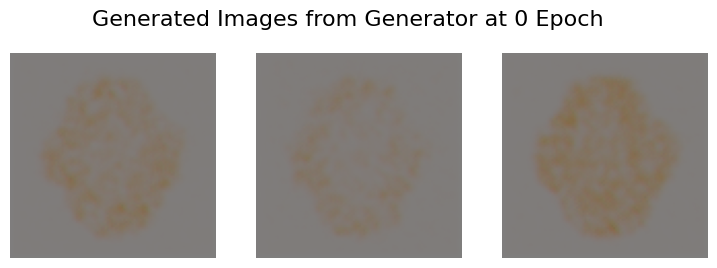

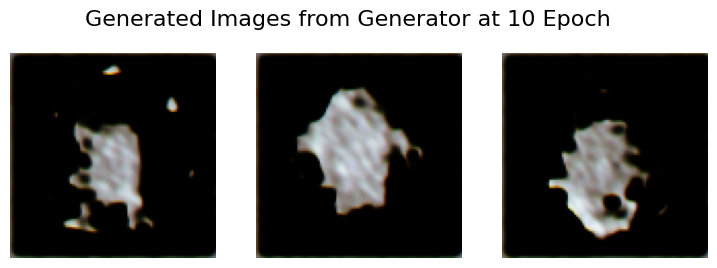

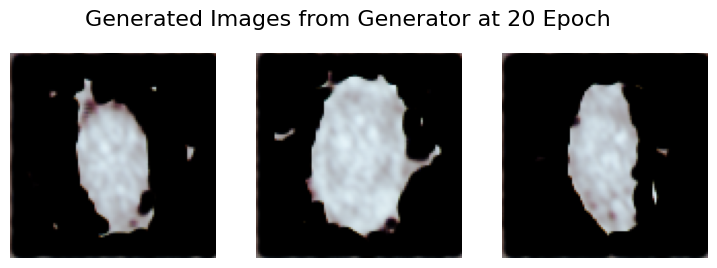

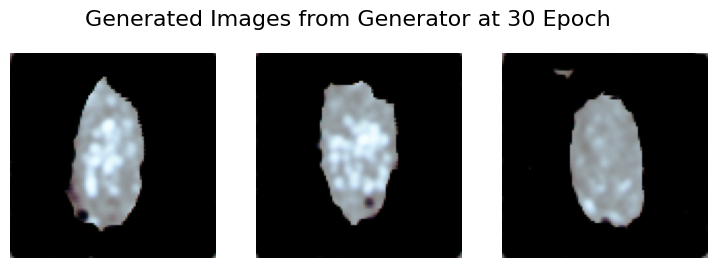

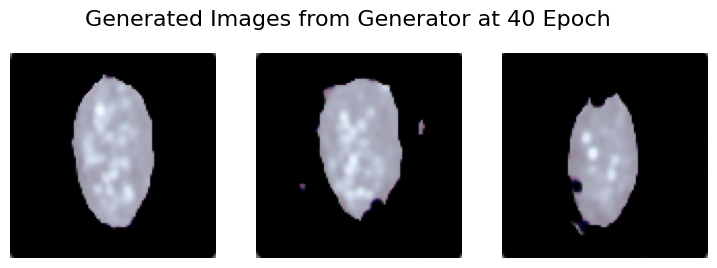

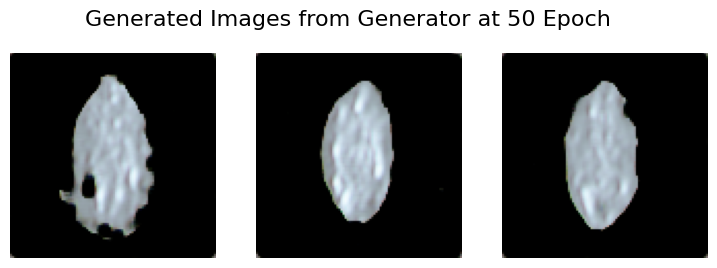

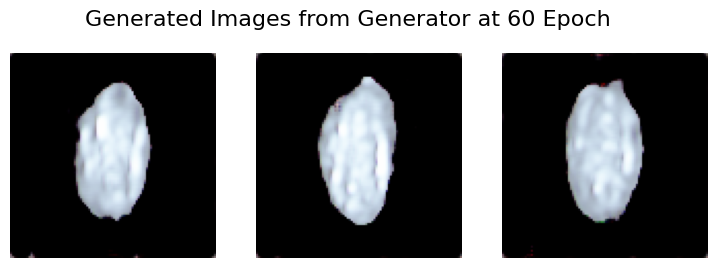

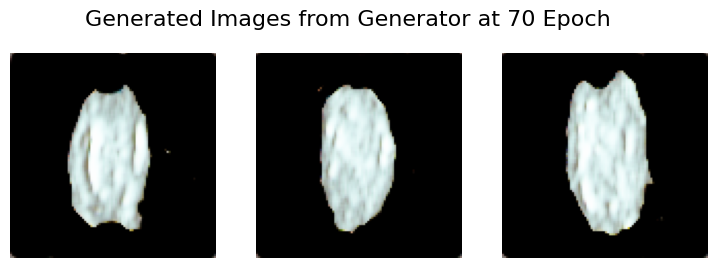

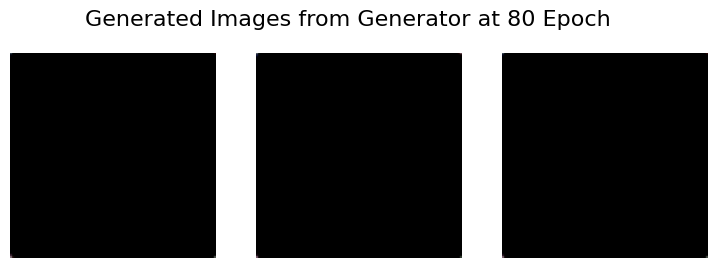

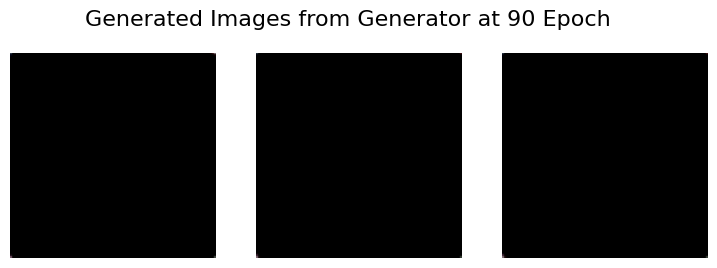

In [13]:
base_dloss, base_gloss = train_GAN(base_generator, base_discriminator, base_GAN, x, epochs=100)

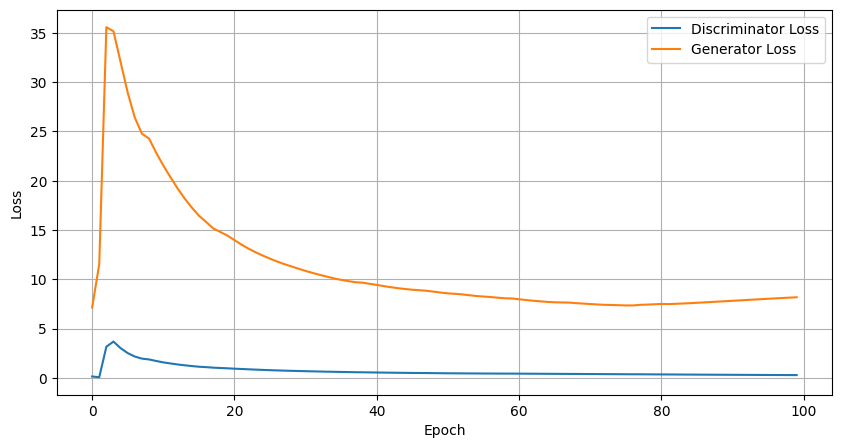

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(base_dloss, label='Discriminator Loss')
plt.plot(base_gloss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 3.b. Modifying Generative Adversarial Network Models

## Modified | 1

**Things to Modified :**  
* Change Learning Rate for the Discriminator to 0.0001  
* Change Learning Rate for the Generator to 0.0002  


Notes : Default learning rate by tf.keras.optimizers.Adam() is 0.001  

**Purposes**  
To make the learning process of GANs model will be more carefully and stable.

In [15]:
base_discriminator.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

base_discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_img = base_generator(z)
validity = base_discriminator(generated_img)

modified1_GAN = Model(z, validity, name="modified2_GAN")
modified1_GAN.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
)

modified1_GAN.summary()

Model: "modified2_GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 100, 100, 3)    │     4,925,971 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │       589,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,515,060 (21.04 MB)

 Trainable params: 4,925,971 (18.79 MB)

 Non-trainable params: 589,089 (2.25 MB)

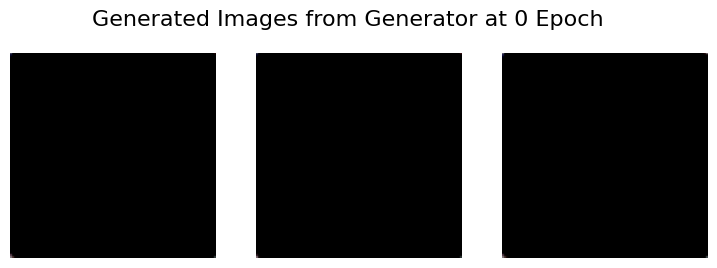

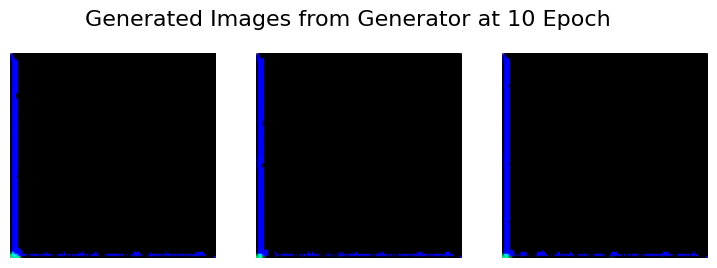

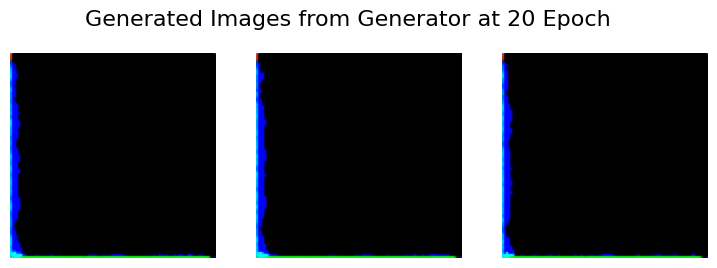

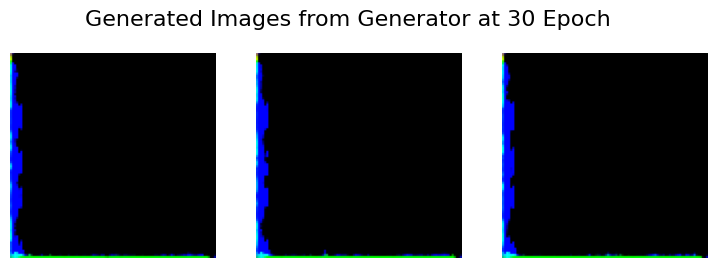

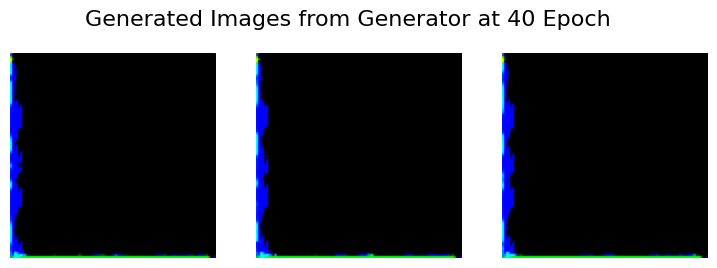

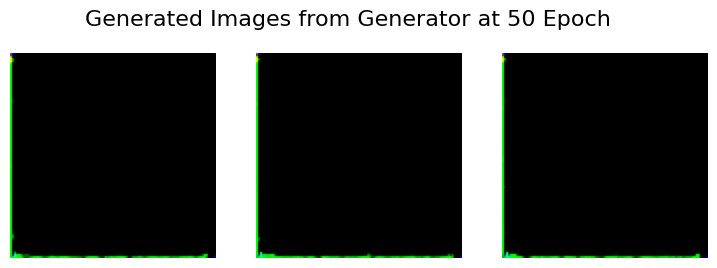

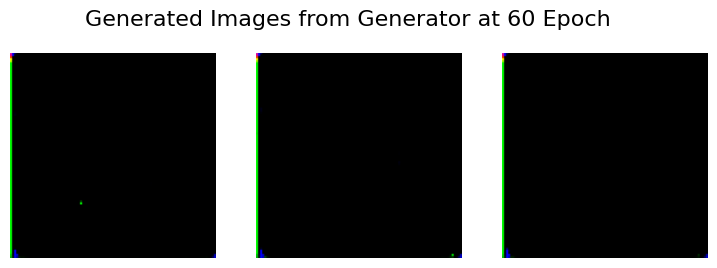

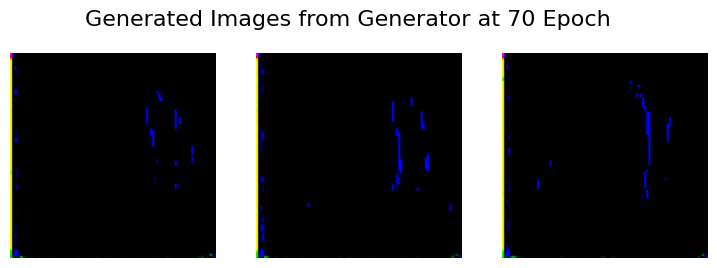

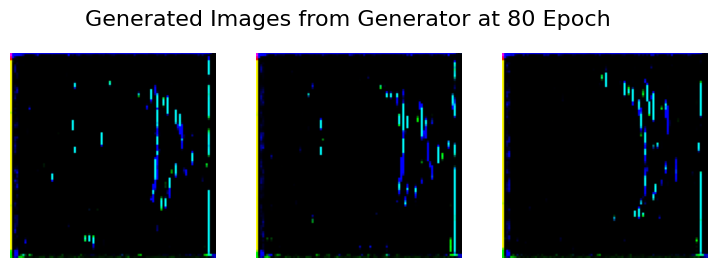

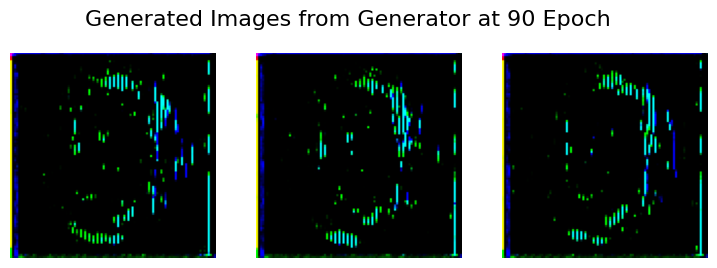

In [16]:
modified1_dloss, modified1_gloss = train_GAN(base_generator, base_discriminator, modified1_GAN, x, epochs=100)

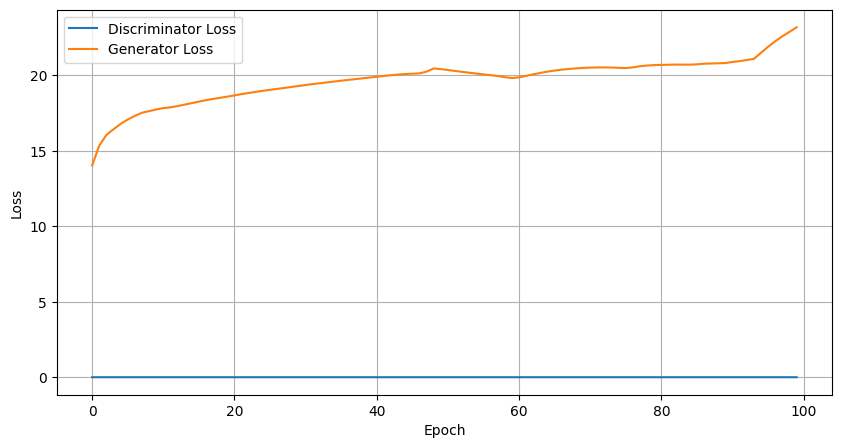

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(modified1_dloss, label='Discriminator Loss')
plt.plot(modified1_gloss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Modified | 2

**Things to Modified :**  
* Change Learning Rate for the Discriminator to 0.001  
* Change Learning Rate for the Generator to 0.002  
* Adding Batch Normalization to the Architecture

**Purposes**  
To make the learning process of GANs model will be more carefully and stable.

In [19]:
def build_modifiedgenerator():
    input_noise = Input(shape=(latent_dim,))
    
    x = Dense(92*92*3, activation='relu')(input_noise)
    x = Reshape((92, 92, 3))(x)
    x = Conv2DTranspose(16, (3,3), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(32, (3,3), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3,3), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    output_img = Conv2DTranspose(3, (3,3), strides=1, padding='valid', activation='tanh')(x)

    model = Model(input_noise, output_img, name='Generator')

    return model

In [22]:
modified_generator = build_modifiedgenerator()
base_discriminator.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

base_discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_img = modified_generator(z)
validity = base_discriminator(generated_img)

modified2_GAN = Model(z, validity, name="modified2_GAN")
modified2_GAN.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002)
)
modified2_GAN.summary()

Model: "modified2_GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 100, 100, 3)    │     4,926,419 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │       589,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,515,508 (21.04 MB)

 Trainable params: 4,926,195 (18.79 MB)

 Non-trainable params: 589,313 (2.25 MB)

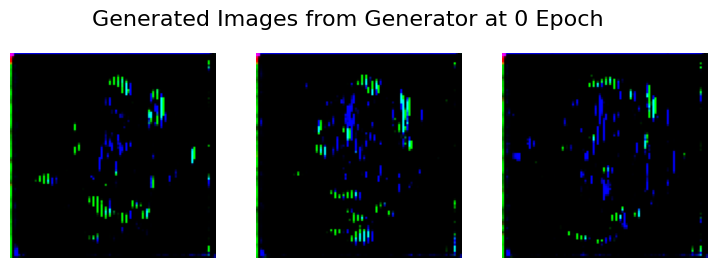

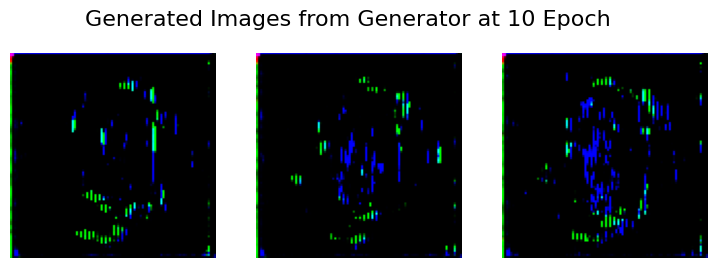

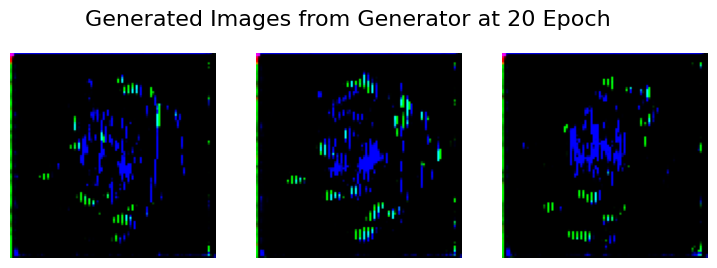

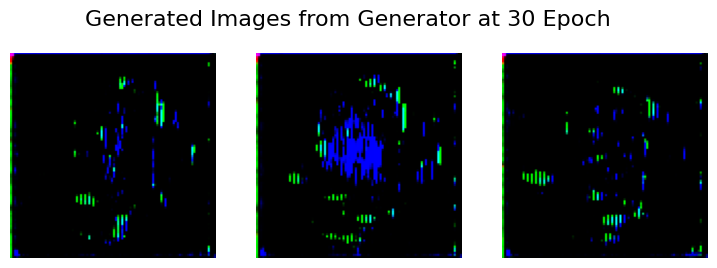

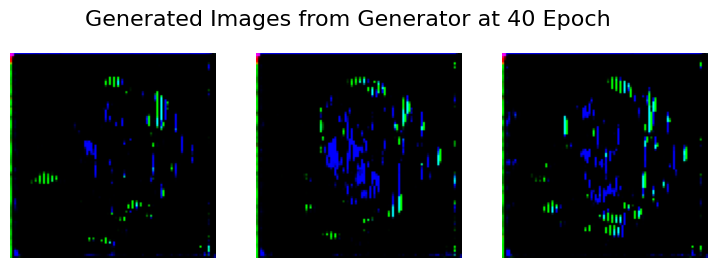

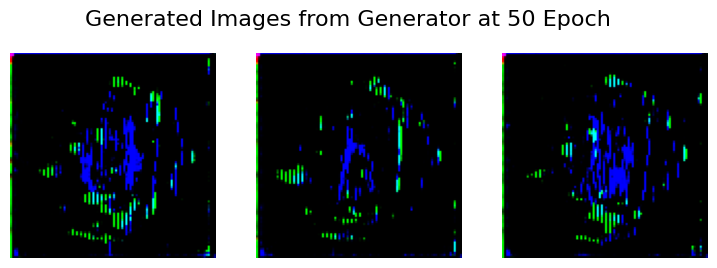

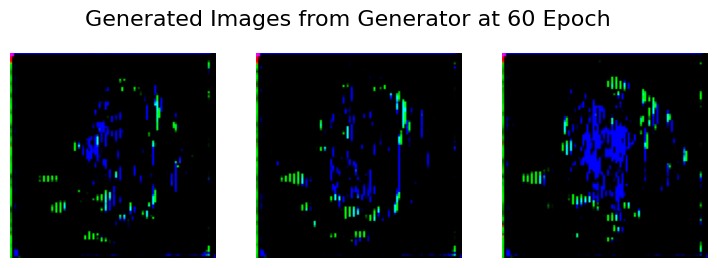

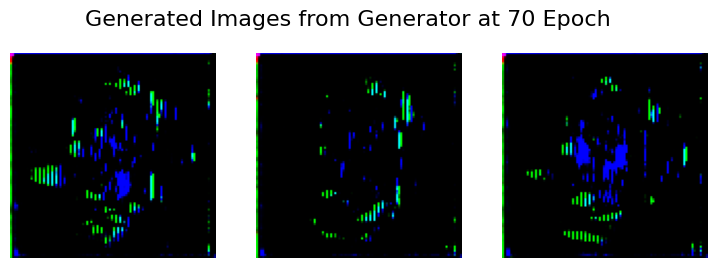

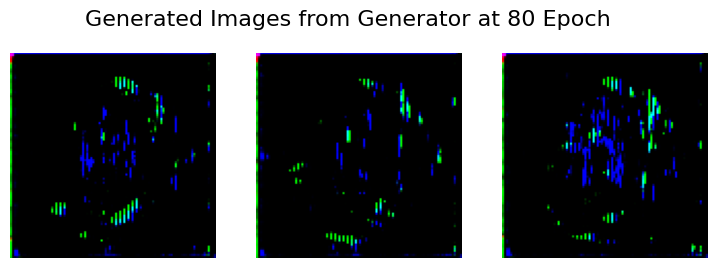

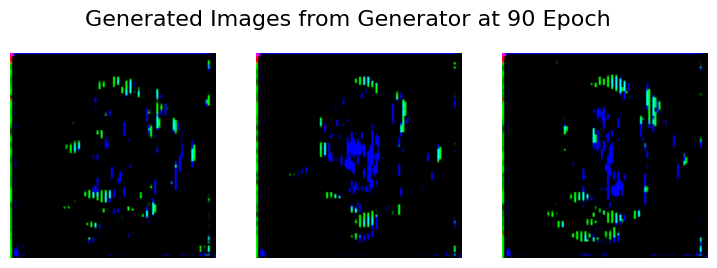

In [23]:
modified2_dloss, modified2_gloss = train_GAN(base_generator, base_discriminator, modified2_GAN, x, epochs=100)

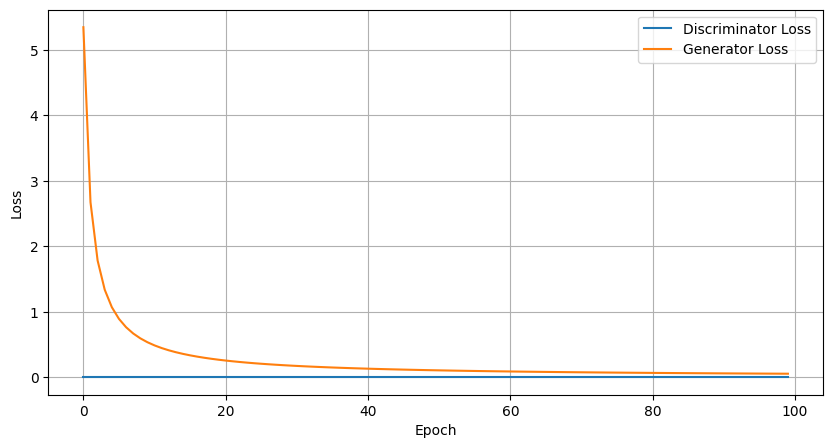

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(modified2_dloss, label='Discriminator Loss')
plt.plot(modified2_gloss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 3.c. Evaluating Models with FID

In [25]:
def resize_images(images):
    resized = np.zeros((x.shape[0], 299, 299, 3), dtype=np.float32)
    for i in range (x.shape[0]):
        resized[i] = resize(images[i], (299,299,3), preserve_range = True, anti_aliasing=True)
    return resized

In [26]:
def generate_images(generator, num_images=x.shape[0], latent_dim = latent_dim):
    noise = tf.random.normal([num_images, latent_dim])
    generated = generator.predict(noise, verbose = 0)
    generated = (generated+1.0)*127.5
    generated = tf.clip_by_value(generated, 0, 255).numpy().astype(np.uint8)
    return generated

In [27]:
def calculate_fid(model, images1, images2):
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    act1 = model.predict(images1, verbose=0)
    act2 = model.predict(images2, verbose=0)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1,rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2,rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1 @ sigma2)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [28]:
def evaluate_multiple_gans(generator_list, real_images, latent_dim=latent_dim, num_images=x.shape[0]):
    real_images_resized = resize_images(real_images[:x.shape[0]])
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    results = []

    for name, generator in generator_list.items():
        fake_images = generate_images(generator, num_images, latent_dim)
        fake_resized = resize_images(fake_images)
        fid = calculate_fid(inception_model, real_images_resized, fake_resized)
        results.append({"Model":name, "FID Score":fid})

    df_result = pd.DataFrame(results)
    return df_result

In [29]:
generator_base = base_generator
generator_mod = modified_generator

real_images = images

generator_dict = {
    "1st Modification": generator_base,
    "2nd Modification": generator_mod
}

df_fid = evaluate_multiple_gans(generator_dict, real_images, latent_dim=latent_dim, num_images=x.shape[0])

df_fid

,Model,FID Score
0,1st Modification,387.672977
1,2nd Modification,338.763638


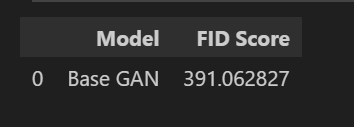

The best model, which is 2nd modification, with the 0.001 and 0.002 learning rate and the batch normalization, resulted 338.76 FID Score means that the images generated by the model are still very different from the real images. This high score suggests that the model has not learned the data distribution well, possibly due to unstable training, weak generator, or very similar outputs (mode collapse).

# FINAL RESULTS

In [36]:
n = 5  
idx = np.random.randint(0, x.shape[0], n)

originals = x[idx]
noise = np.random.normal(0, 1, size=(n, latent_dim))

gan1_outputs = base_generator.predict(noise)
gan2_outputs = modified_generator.predict(noise)
gan1_outputs = (gan1_outputs + 1) / 2.0
gan2_outputs = (gan2_outputs + 1) / 2.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].


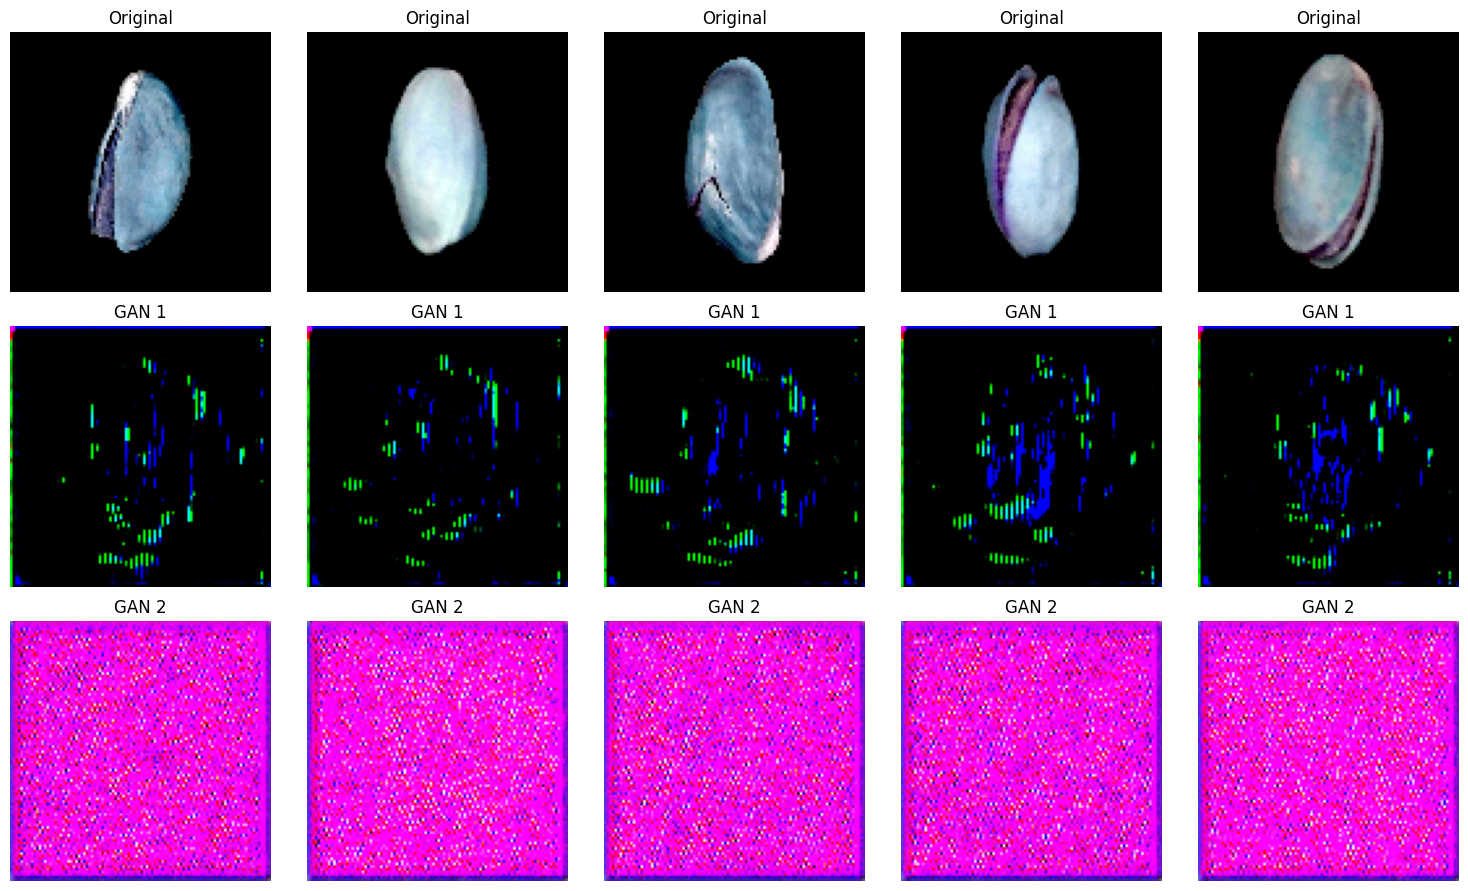

In [37]:
plt.figure(figsize=(n * 3, 9))

for i in range(n):
    # Baris 1: Original
    plt.subplot(3, n, i + 1)
    plt.imshow(originals[i])
    plt.title("Original")
    plt.axis("off")

    # Baris 2: GAN 1
    plt.subplot(3, n, n + i + 1)
    plt.imshow(gan1_outputs[i])
    plt.title("GAN 1")
    plt.axis("off")

    # Baris 3: GAN 2
    plt.subplot(3, n, 2 * n + i + 1)
    plt.imshow(gan2_outputs[i])
    plt.title("GAN 2")
    plt.axis("off")

plt.tight_layout()
plt.show()

# JUSTIFICATION

**GAN 1 : 1st Modified Model - with 0.0001 learning rate on discriminator and 0.0002 on generator**   
The picture seems dark with few digital noise which structured like the original pattern, but there is no natural object colour has appeared.  
Its indicate that the training still not converge yet, and there is a chance for the model to be collapsed because the different images most likely seems have same pattern. 

**GAN 2 : 2nd Modified Model - with 0.001 Discriminator, 0.002 Generator learning rate and Batch Normalization**  
The picture contains all of noise, and there is no pattern that shaped the original images. It shows that the model totally collapse, and the generator failed to generate the images.  

# SUMMARY

**LIMITATION**  

This project contains several limitation, such as :  
* Time, it is not that much to have a trial and error to find the best architecture that can produces a high-quality images.
* Resources, the hardware is not having any ability to support the needs to run the GANs consistently.  


  
**SUGGESTION**  

There are several suggestions for further research :  
1. Overcome the limitation, having a longer time with more capable resources to having more iteration for optimizing the output quality
2. Try the other value of latent dimension and batch size
3. Explore the architecture of generator and discriminator, with ensuring that all the layers work well

# VIDEO EXPLANATION

https://drive.google.com/file/d/1rHRfJu6N5-A3QDUVbv7Z-JgGfjpGGmvl/view?usp=sharing